# Building a Decision Tree Classifier from Scratch using NumPy  


In this project, we will **build a Decision Tree Classifier entirely from scratch using NumPy**, without relying on libraries like `scikit-learn` for the model itself.  

The goal is to deeply understand the **mathematical foundations and algorithmic steps** behind how Decision Trees work, by manually implementing:
- **Entropy** (a measure of impurity),
- **Information Gain** (a measure of how well a split separates the data),
- **Recursive tree construction**, and
- **Prediction using tree traversal**.

We’ll then apply our implementation to a real-world healthcare dataset, the [Breast Cancer Survival dataset from SEER](https://www.kaggle.com/datasets/reihanenamdari/breast-cancer) (Surveillance, Epidemiology, and End Results Program).
  
This dataset contains patient-level information about **breast cancer diagnoses, treatments, and survival outcomes**, and our goal will be to predict whether a patient **survives beyond 5 years** after diagnosis.

## 1. Import Libraries

In [1]:
# Essential libraries
import warnings

# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data modeling
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from scipy.stats import levene, ttest_ind, chi2_contingency

# Suppress unnecessary warnings
warnings.filterwarnings('ignore')

# Visualization setups
sns.set(style='white')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.5

# 2. Import and Preview Dataset

In [2]:
# Load dataset
data = pd.read_csv('Breast_Cancer.csv')

# Preview a few rows
data.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


In [3]:
# Dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

#### Key Observations

- The dataset contains **4,024 patient records** and **16 clinical attributes** related to breast cancer diagnosis, tumor characteristics, hormone receptor status, lymph node involvement, and survival outcomes.
- Each record represents an individual breast cancer patient, with features such as **Age**, **Tumor Size**, **Stage**, and **Hormone Receptor Status**.
- The **target variable** is derived from the patient's **Survival Months** and **Status**, allowing us to predict whether a patient **survived beyond 5 years (≥ 60 months)** after diagnosis.
- All columns in the dataset are **complete with no missing values**, ensuring a clean foundation for analysis. However, some preprocessing steps will still be required before modeling, such as **encoding categorical variables** and **deriving the target variable** (whether a patient survived beyond 5 years, i.e., `Survival Months ≥ 60`).

## 3. Feature Engineering: Creating the Target Variable

Before performing Exploratory Data Analysis (EDA), we need to define the target variable for our prediction task.

In this dataset, the **`Survival Months`** column represents how long a patient lived after diagnosis, while **`Status`** indicates whether they were alive or deceased at the end of the follow-up period.

Since survival analysis in oncology often focuses on **5-year survival rates**, we create a new binary feature called **`Survived_5years`**, where:
- `1` → the patient survived **60 months or more** (≥ 5 years)  
- `0` → the patient survived **less than 60 months**

After creating this target variable, we remove **`Survival Months`** and **`Status`** from the dataset to prevent **data leakage**, as both directly reveal or define the survival outcome.

In [4]:
# Add target variable
data['Survived 5 Years'] = np.where(data['Survival Months'] >= 60, 1, 0)

# Drop unnecessary columns to avoid data leakage
data = data.drop(columns=['Survival Months', 'Status'])

## 4. Exploratory Data Analysis (EDA)

In this section, we explore and understand the characteristics of the dataset before building our model.  

EDA helps us uncover underlying patterns, detect anomalies, identify relationships between features, and gain insights that guide feature selection and preprocessing.

### 4.1. Distribution of Target Variable (`Survived 5 Years`)

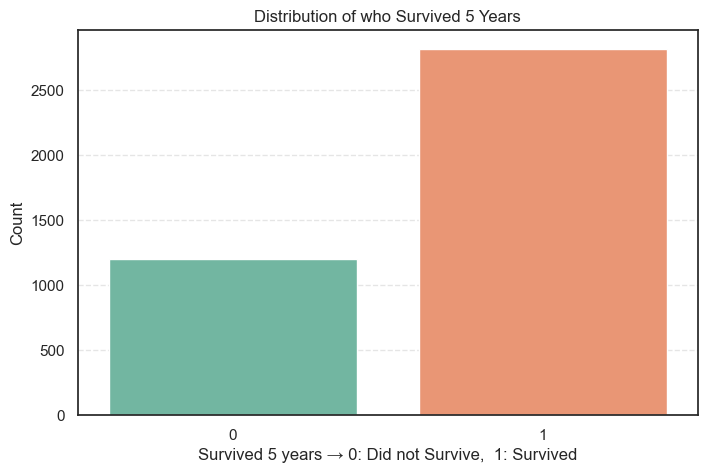

In [5]:
sns.countplot(data=data, x='Survived 5 Years', palette='Set2')
plt.title("Distribution of who Survived 5 Years")
plt.xlabel("Survived 5 years → 0: Did not Survive,  1: Survived")
plt.ylabel("Count")
plt.show()

In [6]:
# Get the distribution counts
data["Survived 5 Years"].value_counts().to_frame(name='Count').assign(
    Percent=lambda x: round((x['Count'] / x['Count'].sum()) * 100, 2))

,Count,Percent
Survived 5 Years,,
1,2821,70.1
0,1203,29.9


#### Key Observations

- Out of the total patients in the dataset, **approximately 70.1% (2,821 patients)** survived beyond 5 years after diagnosis, while **29.9% (1,203 patients)** did not.  
- This indicates that the dataset is **moderately imbalanced**, with a higher proportion of survivors compared to non-survivors.  
- Such imbalance is not extreme, but it’s important to keep in mind when evaluating model performance, accuracy alone may not be a reliable metric; we may need to consider metrics such as **precision, recall, F1-score, or AUC-ROC** later.  
- The survival rate suggests that the dataset represents a relatively positive prognosis group, potentially reflecting effective treatment or early detection among these patients.


### 4.2. Univariate Analysis of Categorical Variables

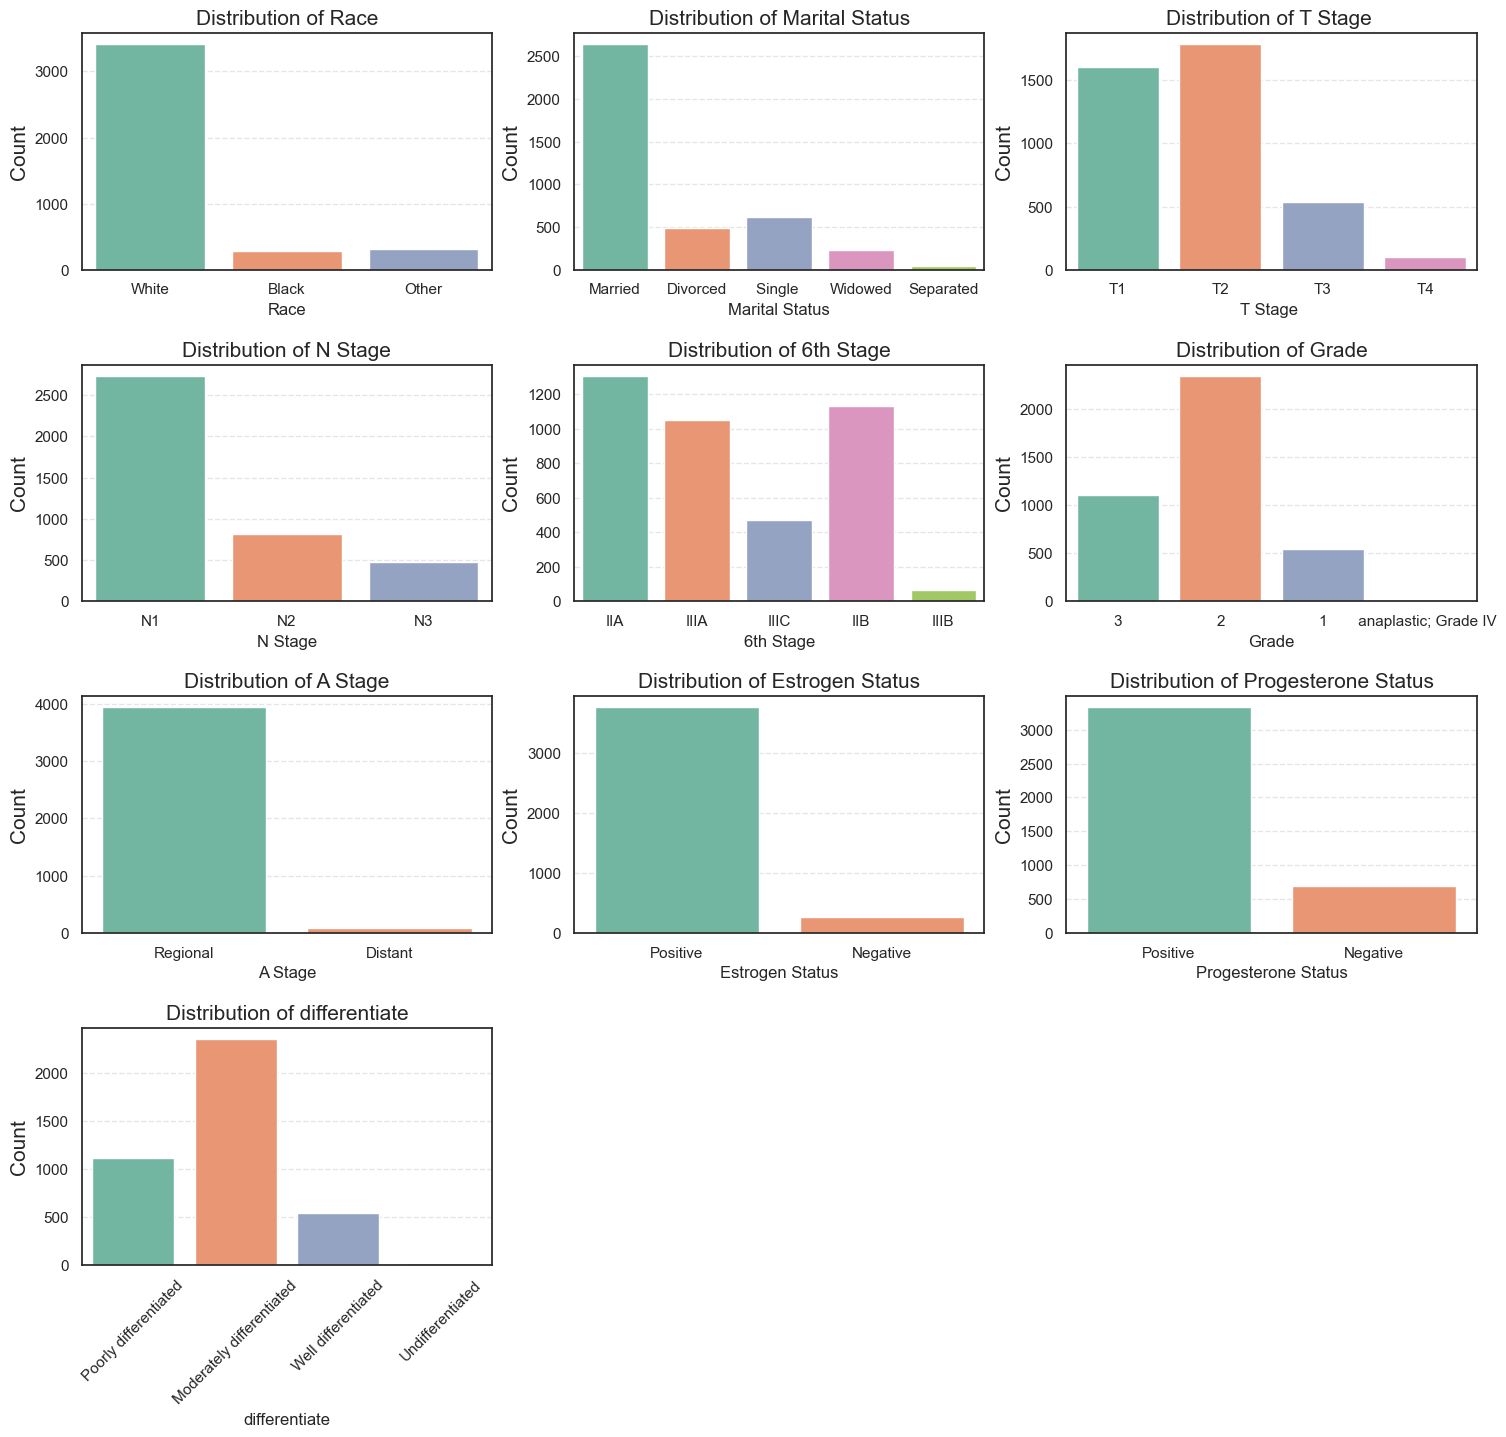

In [7]:
# Select categorical columns
cat_cols = data.select_dtypes(include='object').columns.tolist()

# Make differentiate to be last for better visualization
cat_cols.remove('differentiate')
cat_cols.append('differentiate')

# Plot distributions
plt.figure(figsize=(18, 16))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(4, 3, i)
    sns.countplot(data=data, x=col, palette='Set2')
    plt.title(f"Distribution of {col}", fontsize=15)
    plt.xlabel(col)
    plt.ylabel("Count", fontsize=15)
    if col == 'differentiate':
        plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.4)
plt.show()

In [8]:
# Get the distribution counts
for col in cat_cols:
    counts = data[col].value_counts().to_frame(name='Count').assign(
        Percent=lambda x: round((x['Count'] / x['Count'].sum()) * 100, 2))
    print(f'=== {col} ===')
    print(counts, '\n')

=== Race ===
       Count  Percent
Race                 
White   3413    84.82
Other    320     7.95
Black    291     7.23 

=== Marital Status ===
                Count  Percent
Marital Status                
Married          2643    65.68
Single            615    15.28
Divorced          486    12.08
Widowed           235     5.84
Separated          45     1.12 

=== T Stage  ===
          Count  Percent
T Stage                 
T2         1786    44.38
T1         1603    39.84
T3          533    13.25
T4          102     2.53 

=== N Stage ===
         Count  Percent
N Stage                
N1        2732    67.89
N2         820    20.38
N3         472    11.73 

=== 6th Stage ===
           Count  Percent
6th Stage                
IIA         1305    32.43
IIB         1130    28.08
IIIA        1050    26.09
IIIC         472    11.73
IIIB          67     1.67 

=== Grade ===
                       Count  Percent
Grade                                
2                       2351    58

#### Key Observations

- **Race:** The majority of patients are **White (84.8%)**, followed by smaller proportions of **Other (7.9%)** and **Black (7.2%)** populations. This indicates that the dataset is not racially balanced, with a strong dominance of White patients.  
- **Marital Status:** Most patients were **Married (65.7%)**, while **Single (15.3%)** and **Divorced (12.1%)** individuals form smaller groups. Marital status could be a relevant social factor influencing long-term survival outcomes.  
- **T Stage:** The majority of tumors are in **T2 (44.4%)** and **T1 (39.8%)** stages, representing smaller tumor sizes. Only **2.5%** of patients have **T4** tumors, which are the most advanced in size.  
- **N Stage:** Most patients fall under **N1 (67.9%)**, indicating limited lymph node involvement. Advanced stages (**N2**, **N3**) are progressively less common.  
- **6th Stage (Overall Stage):** The most frequent stages are **IIA (32.4%)**, **IIB (28.1%)**, and **IIIA (26.1%)**, showing that the dataset mainly represents **early-to-mid stage breast cancer**, with very few advanced cases (**IIIB–IIIC**).  
- **Grade & Differentiation:** The largest group of tumors are **Moderately differentiated (58.4%)**, corresponding to **Grade 2**. **Poorly differentiated (27.6%)** and **Well differentiated (13.5%)** tumors follow, while **Anaplastic Grade IV (0.5%)** cases are rare — suggesting most tumors have moderate aggressiveness.  
- **A Stage:** Nearly all patients (**97.7%**) are in the **Regional** stage, meaning cancer has spread to nearby lymph nodes but not distant organs.  
- **Hormone Receptor Status:**  
  - **Estrogen Status:** Predominantly **Positive (93.3%)**, meaning most patients’ cancers express estrogen receptors — often associated with better prognosis and responsiveness to hormone therapy.  
  - **Progesterone Status:** Similarly, **82.7%** are **Positive**, reinforcing the above trend.  

**Overall Interpretation:**  
The dataset represents mostly **middle-stage, hormone-receptor-positive breast cancer patients**, with **moderate tumor grades and regional spread**. These characteristics may partly explain the relatively high 5-year survival rate observed earlier.

### 4.3. Bivariate Analysis of Categorical Variables vs Target (`Survived 5 Years`)

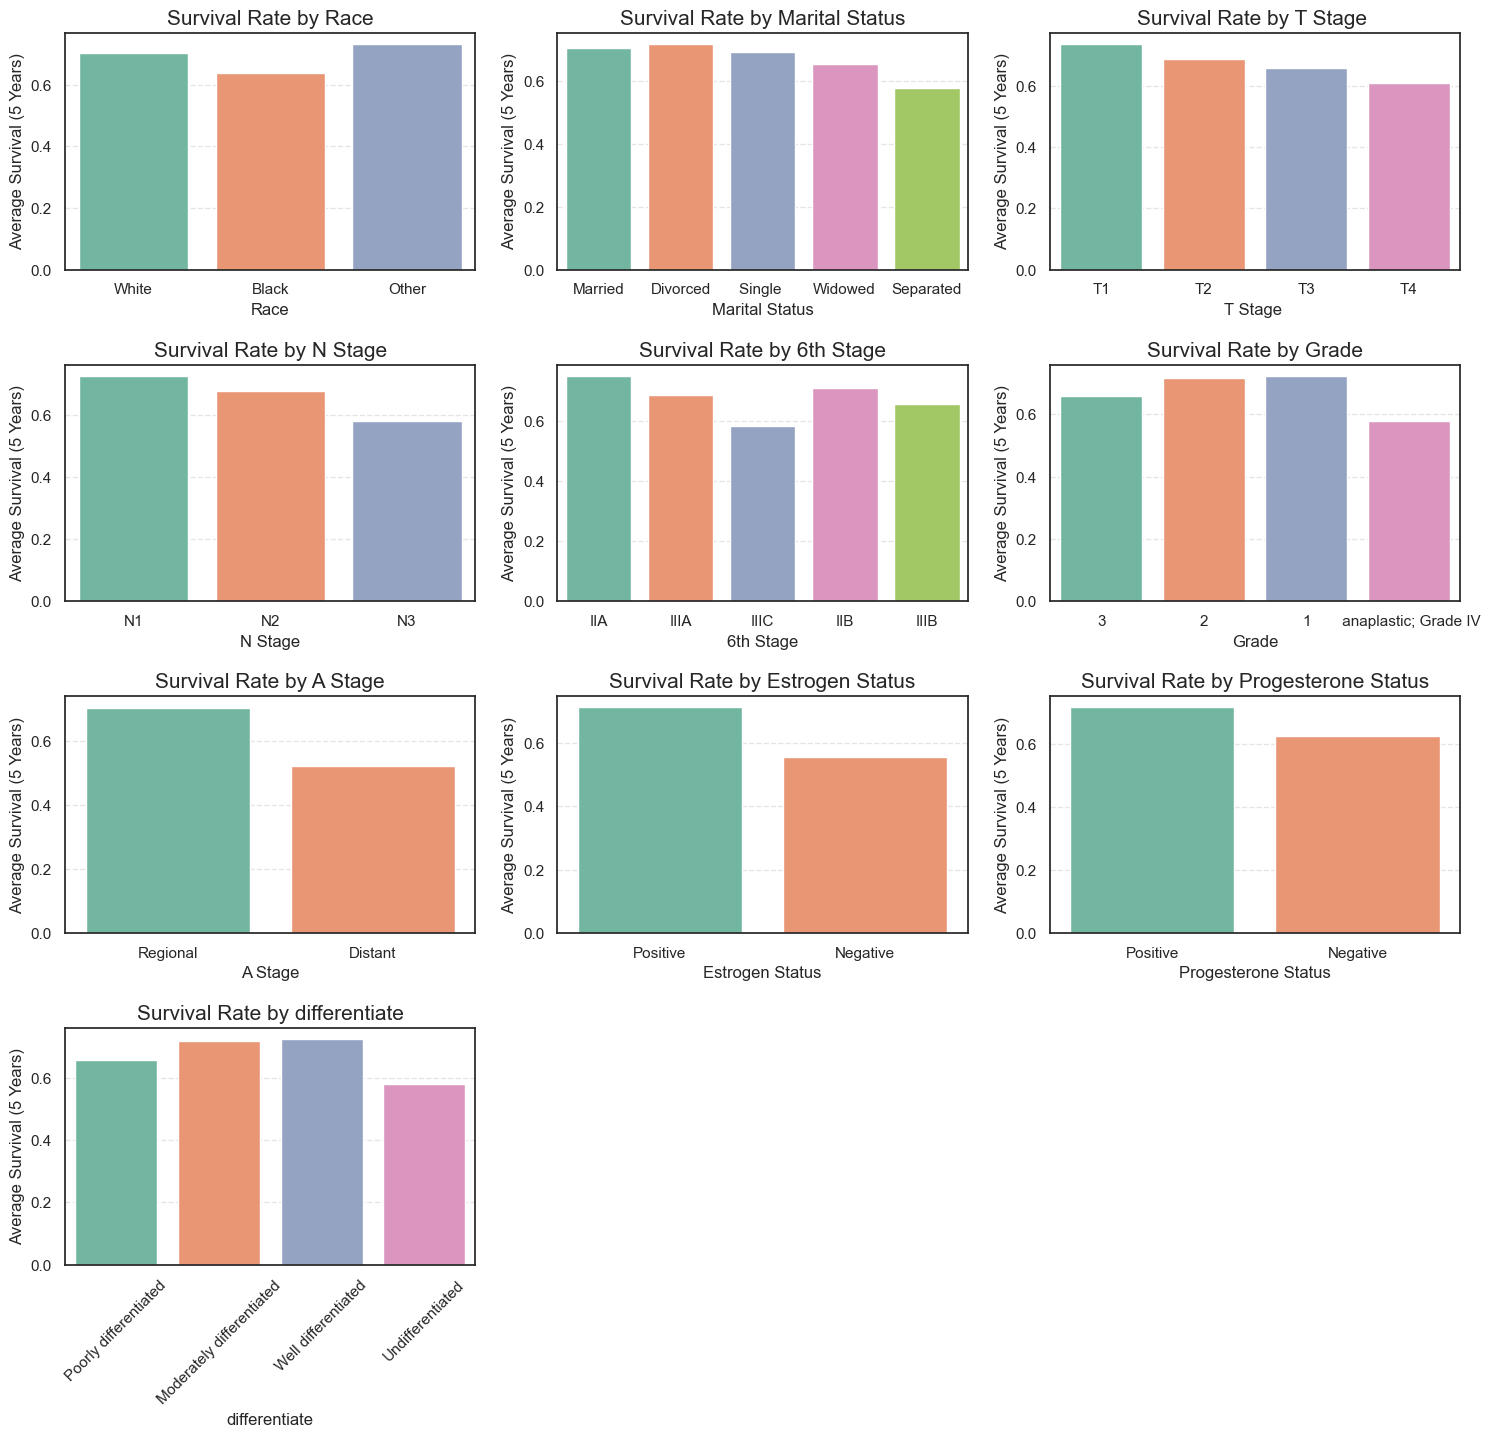

In [9]:
# Plot average survival by variable
plt.figure(figsize=(18, 16))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(4, 3, i)
    sns.barplot(data=data, x=col, y='Survived 5 Years', palette='Set2', ci=False, estimator='mean')
    plt.title(f"Survival Rate by {col}", fontsize=15)
    plt.xlabel(col)
    plt.ylabel("Average Survival (5 Years)")
    if col == 'differentiate':
        plt.xticks(rotation=45)
plt.subplots_adjust(hspace=0.4)
plt.show()

In [10]:
# Calculate average survival by variable
for col in cat_cols:
    mean_survival = data.groupby(col)['Survived 5 Years'].mean().to_frame(name='Mean')
    print(f'=== {col} ===')
    print(mean_survival, '\n')

=== Race ===
           Mean
Race           
Black  0.639175
Other  0.731250
White  0.703487 

=== Marital Status ===
                    Mean
Marital Status          
Divorced        0.718107
Married         0.705638
Separated       0.577778
Single          0.694309
Widowed         0.655319 

=== T Stage  ===
              Mean
T Stage           
T1        0.736120
T2        0.688130
T3        0.656660
T4        0.607843 

=== N Stage ===
             Mean
N Stage          
N1       0.728038
N2       0.679268
N3       0.582627 

=== 6th Stage ===
               Mean
6th Stage          
IIA        0.750958
IIB        0.709735
IIIA       0.685714
IIIB       0.656716
IIIC       0.582627 

=== Grade ===
                           Mean
Grade                          
 anaplastic; Grade IV  0.578947
1                      0.723757
2                      0.717142
3                      0.657966 

=== A Stage ===
              Mean
A Stage           
Distant   0.521739
Regional  0.705239 

==

#### Key Observations

- **Race:** Survival rates are relatively similar across races, though **White (70.3%)** and **Other (73.1%)** patients have slightly higher survival than **Black (63.9%)** patients.

- **Marital Status:** **Divorced (71.8%)** and **Married (70.6%)** patients show higher 5-year survival compared to **Widowed (65.5%)** and especially **Separated (57.8%)** individuals. Social and emotional support may play a role in recovery outcomes.

- **Tumor (T) Stage:** As expected, survival declines with more advanced tumor stages — from **T1 (73.6%)** to **T4 (60.8%)**.  
  Smaller tumors correspond to better prognosis.

- **Node (N) Stage:** Similarly, survival decreases as lymph node involvement increases: **N1 (72.8%) → N3 (58.3%)**, confirming the prognostic importance of nodal spread.

- **6th Stage (Overall Cancer Stage):** Early stages have much better outcomes — **Stage IIA (75.1%)** patients show significantly higher survival compared to **Stage IIIC (58.3%)**.

- **Grade / Differentiate:** Patients with **well or moderately differentiated tumors (~72%)** survive longer than those with **poorly differentiated (65.8%)** or **undifferentiated tumors (57.9%)**. This aligns with biological aggressiveness of poorly differentiated cancers.

- **A Stage (Extent of Spread):** Patients with **regional tumors (70.5%)** fare much better than those with **distant metastasis (52.1%)**, highlighting how metastasis drastically lowers survival chances.

- **Hormone Receptor Status:**
  - **Estrogen-positive:** 71.2% survival vs 55.4% for estrogen-negative.
  - **Progesterone-positive:** 71.7% survival vs 62.6% for progesterone-negative.  
  Hormone receptor positivity is therefore associated with better survival, likely due to responsiveness to hormone-based therapy.

In [11]:
# Chi - square test
alpha = 0.05
for col in cat_cols:
    cont_table = pd.crosstab(data[col], data['Survived 5 Years'])
    c_stat, p_value, _, _ = chi2_contingency(cont_table)
    print(f'=== {col} ===')
    print(f'Stats: {c_stat}, P-Value: {p_value}')
    print(f'Null Hypothesis (Ho): There is no relation between {col} and those who survived after 5 years.')
    decision = "Reject hypothesis." if p_value < alpha else "Fail to reject hypothesis."
    print("Decision:", decision, '\n')

=== Race ===
Stats: 6.8050193904269065, P-Value: 0.03328961823851946
Null Hypothesis (Ho): There is no relation between Race and those who survived after 5 years.
Decision: Reject hypothesis. 

=== Marital Status ===
Stats: 6.681159982375642, P-Value: 0.15372776302583785
Null Hypothesis (Ho): There is no relation between Marital Status and those who survived after 5 years.
Decision: Fail to reject hypothesis. 

=== T Stage  ===
Stats: 20.068651598232357, P-Value: 0.00016427141114880962
Null Hypothesis (Ho): There is no relation between T Stage  and those who survived after 5 years.
Decision: Reject hypothesis. 

=== N Stage ===
Stats: 42.93428827031285, P-Value: 4.752671090245094e-10
Null Hypothesis (Ho): There is no relation between N Stage and those who survived after 5 years.
Decision: Reject hypothesis. 

=== 6th Stage ===
Stats: 49.30617997295906, P-Value: 5.040095221861289e-10
Null Hypothesis (Ho): There is no relation between 6th Stage and those who survived after 5 years.
Decis

#### Key Observations
  
* **Race:** Significant association with 5-year survival _(p = 0.033)_.
    
*   **Marital Status:** No significant association _(p = 0.154)_.
    
*   **T Stage:** Strongly associated with survival _(p < 0.001)_.
    
*   **N Stage:** Highly significant association _(p < 0.001)_.
    
*   **6th Stage:** Highly significant association _(p < 0.001)_.
    
*   **Grade:** Significant association _(p = 0.001)_.
    
*   **A Stage:** Strongly associated with survival _(p < 0.001)_.
    
*   **Estrogen Status:** Highly significant association _(p < 0.001)_.
    
*   **Progesterone Status:** Highly significant association _(p < 0.001)_.
    
*   **Differentiate:** Significant association _(p = 0.001)_.
    
**Summary:** Most clinical features (stage, grade, hormone status, differentiation) show statistically significant relationships with 5-year survival and are likely informative predictors; **Marital Status** does not appear significant at α = 0.05.

### 4.4. Univariate Analysis of Numerical Variables

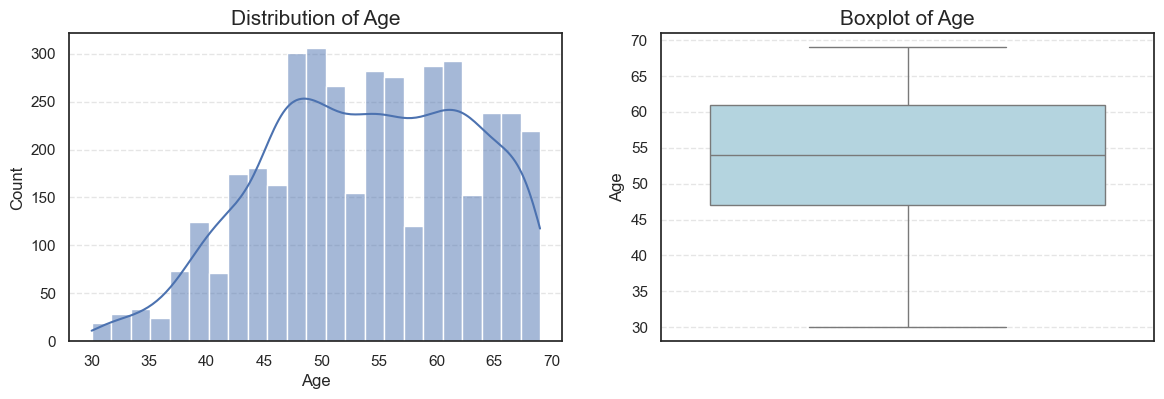

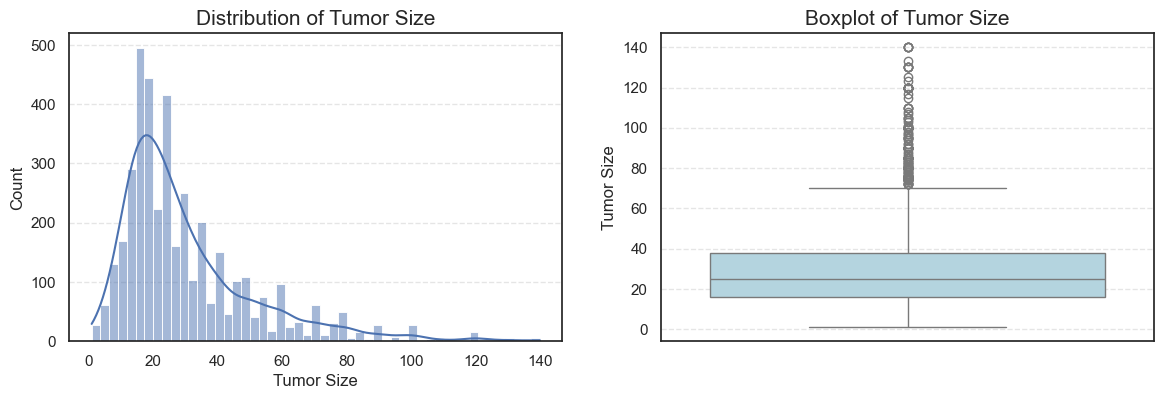

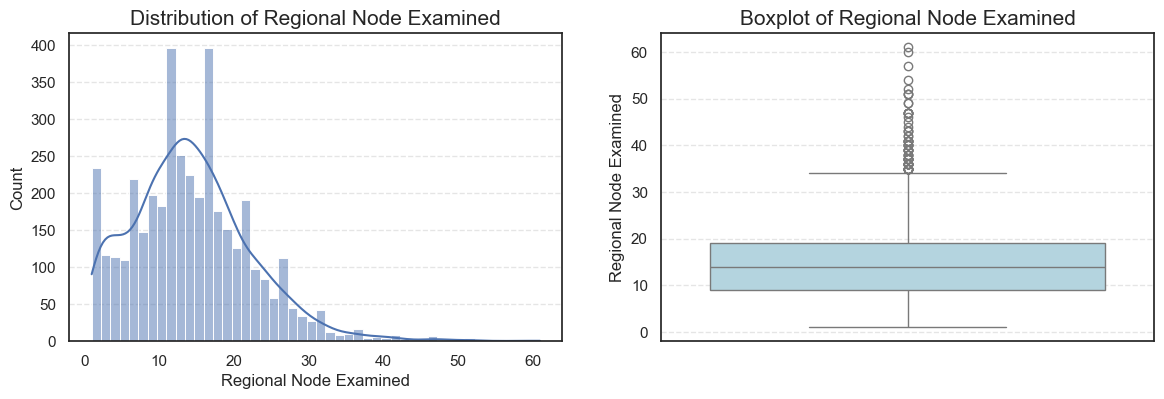

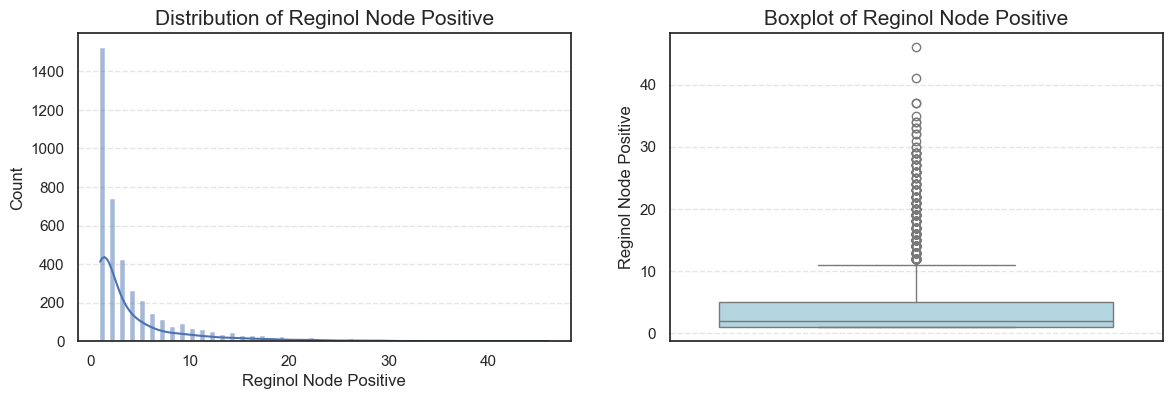

In [12]:
# Select numerical columns
num_cols = data.drop(columns=['Survived 5 Years']).select_dtypes(include='number').columns

# Plot distribution of numerical variables
for col in num_cols:
    plt.figure(figsize=(14, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=data, x=col, kde=True)
    plt.title(f"Distribution of {col}", fontsize=15)
    plt.xlabel(col)
    plt.ylabel("Count")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=data, y=col, color='lightblue')
    plt.title(f"Boxplot of {col}", fontsize=15)
    plt.ylabel(col)

plt.show()

In [13]:
# Statistical information of numerical variables
data[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Age,4024.0,53.972167,8.963134,30.0,47.0,54.0,61.0,69.0
Tumor Size,4024.0,30.473658,21.119696,1.0,16.0,25.0,38.0,140.0
Regional Node Examined,4024.0,14.357107,8.099675,1.0,9.0,14.0,19.0,61.0
Reginol Node Positive,4024.0,4.158052,5.109331,1.0,1.0,2.0,5.0,46.0


In [14]:
# Check for outliers and skewness
for col in num_cols:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - iqr * 1.5
    upper = q3 + iqr * 1.5
    outliers = data[(data[col] < lower) | (data[col] > upper)][col]
    print(f'=== {col} ===')
    print('Outliers:', len(outliers))
    print('Skew:', data[col].skew(), '\n')

=== Age ===
Outliers: 0
Skew: -0.2203727859678868 

=== Tumor Size ===
Outliers: 222
Skew: 1.7397498006705898 

=== Regional Node Examined ===
Outliers: 72
Skew: 0.8292737694534275 

=== Reginol Node Positive ===
Outliers: 344
Skew: 2.702535859800024 



#### Key Observations

*   **Age:** The age of patients ranges between **30 and 69 years**, with a mean of approximately **54 years**.The distribution is nearly **symmetric** _(skew = -0.22)_ and shows **no outliers**, indicating a fairly balanced spread of ages.
    
*   **Tumor Size:** Tumor size has a mean of **30.5 mm**, but the distribution is **right-skewed** _(skew = 1.74)_.There are **222 outliers**, mostly on the higher end, suggesting a few patients with unusually large tumors.The majority of patients have tumor sizes below **40 mm**, as shown in the histogram.
    
*   **Regional Node Examined:** The number of lymph nodes examined has a mean of **14.36**, with a slight **right skew** _(skew = 0.83)_.There are **72 outliers**, possibly representing cases with extensive node examination.
    
*   **Reginol Node Positive:** This feature is **highly right-skewed** _(skew = 2.70)_ with **344 outliers**.Most patients have **1–5 positive nodes**, while a few cases show much higher counts, indicating possible disease progression.
    

**Summary:** The numerical features show varying distributions — while **Age** is well-behaved and symmetric, **Tumor Size**, **Regional Node Examined**, and **Reginol Node Positive** exhibit **right-skewed distributions** with several **high-value outliers**, typical of clinical data in oncology.

### 4.5. Bivariate Analysis of Numerical Variables vs Target (`Survived 5 Years`)

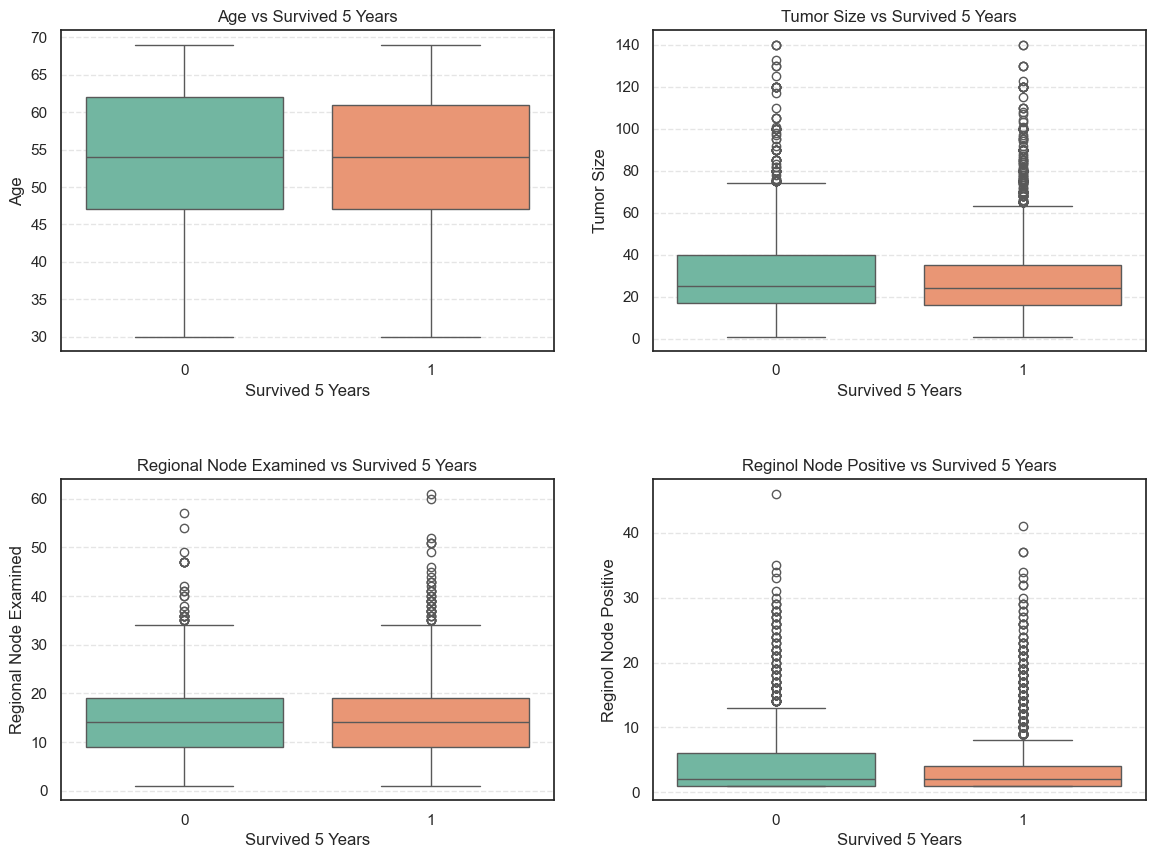

In [15]:
# Plot numerical variables vs target
plt.figure(figsize=(14, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=data, x='Survived 5 Years', y=col, palette='Set2')
    plt.title(f"{col} vs Survived 5 Years", fontsize=12)
    plt.xlabel('Survived 5 Years')
    plt.ylabel(col)
plt.subplots_adjust(hspace=0.4)
plt.show()

In [16]:
# Compute statistical information of variable vs target
stats = data.groupby('Survived 5 Years')[num_cols].agg(['mean', 'median', 'std']).T
stats

Survived 5 Years                       0          1
Age                    mean    54.091438  53.921305
                       median  54.000000  54.000000
                       std      9.185006   8.867994
Tumor Size             mean    32.885287  29.445232
                       median  25.000000  24.000000
                       std     22.790775  20.282603
Regional Node Examined mean    14.561929  14.269762
                       median  14.000000  14.000000
                       std      8.410047   7.963563
Reginol Node Positive  mean     4.950956   3.819922
                       median   2.000000   2.000000
                       std      5.940646   4.670813

In [17]:
# T-Test
alpha = 0.05
for col in num_cols:
    survived = data[data["Survived 5 Years"] == 1][col]
    didnt_survive = data[data["Survived 5 Years"] == 0][col]
    _, lev_p = levene(survived, didnt_survive, center='median')
    equal_var = lev_p >= alpha
    t_stat, p_value = ttest_ind(survived, didnt_survive, equal_var=equal_var)
    print(f'=== {col} ===')
    print(f'Stats: {t_stat}, P Value: {p_value}')
    print(f'Null Hypothesis (Ho): Average {col} are the same with those who survived 5 years.')
    decision = "Reject null hypothesis." if p_value < alpha else "Fail to reject null hypothesis."
    print('Decision:', decision, '\n')

=== Age ===
Stats: -0.5511856397782932, P Value: 0.5815370399673709
Null Hypothesis (Ho): Average Age are the same with those who survived 5 years.
Decision: Fail to reject null hypothesis. 

=== Tumor Size ===
Stats: -4.526390615743846, P Value: 6.34365713155091e-06
Null Hypothesis (Ho): Average Tumor Size are the same with those who survived 5 years.
Decision: Reject null hypothesis. 

=== Regional Node Examined ===
Stats: -1.024831281625778, P Value: 0.3055574426164092
Null Hypothesis (Ho): Average Regional Node Examined are the same with those who survived 5 years.
Decision: Fail to reject null hypothesis. 

=== Reginol Node Positive ===
Stats: -5.8744384731883015, P Value: 5.013101228450924e-09
Null Hypothesis (Ho): Average Reginol Node Positive are the same with those who survived 5 years.
Decision: Reject null hypothesis. 



#### Key Observations


- **Age:** The average age of survivors (≈53.9 years) and non-survivors (≈54.1 years) is nearly identical, and the t-test (p = 0.58) confirms that this difference is **not statistically significant**. Age does not appear to have a strong influence on five-year survival in this dataset.

- **Tumor Size:** Non-survivors have a **larger mean tumor size** (≈32.9) compared to survivors (≈29.4). The t-test (p < 0.001) shows this difference is **statistically significant**. Smaller tumor sizes are associated with a higher likelihood of surviving beyond five years.

- **Regional Node Examined:** Both groups have similar averages (≈14 nodes), and the t-test (p = 0.31) indicates **no significant difference**. The number of regional nodes examined does not significantly impact survival outcomes.

- **Reginol Node Positive:** Non-survivors have a **higher average of positive nodes** (≈4.95) compared to survivors (≈3.82). The t-test (p < 0.001) confirms this difference is **statistically significant**. A higher number of positive regional nodes is strongly associated with lower survival rates.

**Summary:** Among the numerical variables, **Tumor Size** and **Reginol Node Positive** show significant relationships with five-year survival. Patients with **smaller tumors** and **fewer positive lymph nodes** are more likely to survive, while **Age** and **Regional Node Examined** do not exhibit meaningful differences across survival outcomes.


## 5. Feature Encoding

Before training our machine learning model, we need to convert categorical variables into numerical form since most algorithms (including Decision Trees) work with numeric data.  

In this step, we will perform **feature encoding** on all categorical variables. This process ensures that our dataset is entirely numerical and ready for model training.

In [18]:
# Mapping dict
encoding_dict = {
    "Race": {'White': 1, 'Black': 2, 'Other': 3},
    "Marital Status": {'Married': 1, 'Divorced': 2, 'Single ': 3, 'Widowed': 4, 'Separated': 5},
    "T Stage ": {'T1': 1, 'T2': 2, 'T3': 3, 'T4': 4},
    "N Stage": {'N1': 1, 'N2': 2, 'N3': 3},
    "6th Stage": {'IIA': 1, 'IIIA': 2, 'IIIC': 3, 'IIB': 4, 'IIIB': 5},
    "Grade": {'3': 3, '2': 2, '1': 1, ' anaplastic; Grade IV': 4},
    "A Stage": {'Regional': 1, 'Distant': 2},
    "Estrogen Status": {'Positive': 1, 'Negative': 0},
    "Progesterone Status": {'Positive': 1, 'Negative': 0},
    "differentiate": {
        'Poorly differentiated': 1,
        'Moderately differentiated': 2,
        'Well differentiated': 3,
        'Undifferentiated': 0
    }
}

# Map to encoding
for col in cat_cols:
    data[col] = data[col].replace(encoding_dict[col])

## 6. Implementing a Decision Tree from Scratch (Using NumPy)

In this section, we will build a **Decision Tree Classifier from scratch** using only **NumPy** without relying on high-level machine learning libraries like Scikit-learn.  

This hands-on implementation will help us understand the internal mechanics of how a Decision Tree works, including:
- **Entropy and Information Gain** — the metrics that guide the splitting of nodes.
- **Recursive Tree Building** — how the model partitions the data into smaller subsets.
- **Prediction Process** — how the final tree makes decisions on unseen data.

By implementing the algorithm manually, we gain an intuitive understanding of the decision-making process in tree-based models, which is essential for explainability and interpretability — particularly important in the **healthcare domain**, where understanding “why” a model made a certain prediction is as critical as the prediction itself.

### 6.1. Defining Entropy

**Entropy** is a key concept in building Decision Trees. It measures the **impurity** or **uncertainty** in a dataset.  

In the context of classification, entropy quantifies how mixed the target labels are within a node:
- A node with **pure classes** (e.g., all patients either survived or did not survive) has **low entropy** (close to 0).
- A node with a **mix of classes** (roughly equal number of survivors and non-survivors) has **high entropy** (close to 1).

The goal of a Decision Tree is to split the data in a way that **reduces entropy** as much as possible, thereby creating nodes that are more homogeneous in terms of the target variable.

Mathematically, entropy is defined as:

$$
H(S) = - \sum_{i=1}^{c} p_i \log_2(p_i)
$$

where:
- $ c $ = number of classes  
- $ p_i $ = proportion of samples belonging to class $ i $ 

We’ll now implement a function to calculate the entropy of a given dataset using NumPy.


In [19]:
def entropy(y):
    """
    Calculate the entropy of a target variable.
    
    :param y: (array) Target variable (e.g., class labels).
    :return: (float) Entropy value representing the impurity of the node.
    """

    # Get unique class labels and their counts
    unique_classes, counts = np.unique(y, return_counts=True)

    # Compute probabilities of each class
    probabilities = counts / len(y)

    # Compute entropy using the formula: -sum(p * log2(p))
    entropy_value = -np.sum(probabilities * np.log2(probabilities + 1e-9))  # add epsilon to avoid log(0)

    return entropy_value

### 6.2. Information Gain

Information Gain measures how much uncertainty in the target variable is reduced after splitting the data based on a particular feature. It helps us decide **which feature and threshold** to use when growing the decision tree.

Mathematically:

$$
\text{Information Gain} = H(Parent) - \sum_{i}\frac{N_{i}}{N}H(Child_{i})
$$

Where:

*   $ H(Parent) $ → entropy of the parent node
    
*   $ H(Child_{i}) $ → entropy of each child node after splitting on feature XXX
    
*  $ \frac{N_{i}}{N} $ → proportion of samples in that child node
    

In the next step, we’ll implement the **information gain** function using NumPy.

In [20]:
def information_gain(parent, left_child, right_child):
    """
    Calculate Information Gain for a potential split in a decision tree.
    
    :param parent: (np.ndarray) Target values (y) of the parent node before the split.
    :param left_child: (np.ndarray) Target values (y) of the left child node after the split.
    :param right_child: (np.ndarray) Target values (y) of the right child node after the split.
    :return: (float) Information Gain from the split.
    """

    # Calculate the entropy of the parent node
    parent_entropy = entropy(parent)

    # Calculate the weighted average of the children’s entropy
    n_parent = len(parent)
    n_left, n_right = len(left_child), len(right_child)
    weighted_entropy = (n_left / n_parent) * entropy(left_child) + (n_right / n_parent) * entropy(right_child)

    # Information Gain = reduction in entropy
    gain = parent_entropy - weighted_entropy

    return gain

### 6.3. Selecting the Best Split

To grow a decision tree, we must find the **best feature** and **best threshold** that maximizes **Information Gain**.

For each feature in our dataset:

1.  We test all possible split points (unique values).
    
2.  For each split, we divide the data into left and right subsets.
    
3.  We calculate the information gain for that split.
    
4.  The split that gives the **highest information gain** is selected.
    

This process allows the decision tree to choose the feature and threshold that most effectively separates the target classes, reducing uncertainty at each step.

In [21]:
def best_split(X, y):
    """
    Finds the best feature and threshold to split the dataset based on maximum Information Gain.
    
    :param X: (numpy.ndarray) Feature matrix of shape (n_samples, n_features)
    :param y: (numpy.ndarray) Target vector of shape (n_samples,)
    :return: (tuple) best_feature, best_threshold, best_info_gain
    """

    n_samples, n_features = X.shape
    best_info_gain = -1
    best_feature = None
    best_threshold = None

    # Loop through all features
    for feature_idx in range(n_features):
        feature_values = X[:, feature_idx]
        thresholds = np.unique(feature_values)

        # Try every unique value as a potential split point
        for threshold in thresholds:
            left_mask = feature_values <= threshold
            right_mask = feature_values > threshold

            if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                continue  # skip invalid splits

            # Compute information gain
            info_gain = information_gain(y, y[left_mask], y[right_mask])

            # Update best split if better info gain found
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_feature = feature_idx
                best_threshold = threshold

    return best_feature, best_threshold, best_info_gain

### 6.4. Building the Decision Tree Recursively

Now that we can compute **entropy** and determine the **best feature and threshold** to split the data, we can proceed to build the **Decision Tree recursively**.

In this step, we will:

*   Define a recursive function that:
    
    *   Finds the best split using information gain.
        
    *   Creates **left** and **right** child nodes based on the split.
        
    *   Continues splitting until a stopping condition is met (e.g., maximum depth reached or all samples belong to one class).
        
*   The resulting tree will be represented as a **nested dictionary**, where each internal node contains:
    
    *   The **feature index** and **threshold** for the split.
        
    *   The **left** and **right** subtrees.
        
*   Leaf nodes will store the **most common class label** among the samples that reach that node.
    

This recursive approach mimics how real decision trees like those in scikit-learn are built, by greedily selecting the best splits to reduce impurity at every level.

In [22]:
def build_tree(X, y, depth=0, max_depth=5):
    """
    Recursively builds a Decision Tree based on Information Gain.
    
    :param X: (np.ndarray) Feature matrix.
    :param y: (np.ndarray) Target vector.
    :param depth: (int) Current depth of the tree (default is 0).
    :param max_depth: (int) Maximum depth allowed for the tree (default is 5).
    :return: (dict) Nested dictionary representing the Decision Tree.
    """

    # Get unique class labels and their counts
    classes, counts = np.unique(y, return_counts=True)

    # If all samples belong to one class or max depth reached, return leaf node
    if len(classes) == 1:
        return {'label': classes[0]}
    if depth >= max_depth:
        return {'label': classes[np.argmax(counts)]}

    # Find the best feature and threshold for splitting
    best_feature, best_threshold, best_info_gain = best_split(X, y)

    # If no useful split is found, return majority class as a leaf node
    if best_info_gain == 0 or best_feature is None:
        return {'label': classes[np.argmax(counts)]}

    # Split the data into left and right subsets
    left_mask = X[:, best_feature] <= best_threshold
    right_mask = ~left_mask

    # Recursively build the left and right branches
    left_subtree = build_tree(X[left_mask], y[left_mask], depth + 1, max_depth)
    right_subtree = build_tree(X[right_mask], y[right_mask], depth + 1, max_depth)

    # Return the current node
    return {
        'feature': best_feature,
        'threshold': best_threshold,
        'gain': best_info_gain,
        'left': left_subtree,
        'right': right_subtree
    }

### 6.5. Making Predictions with the Decision Tree

Now that we have constructed our Decision Tree, the next step is to use it for making predictions on unseen data.

The prediction process involves traversing the tree from the root node to a leaf node for each sample:

*   At each internal node, we compare the feature value with the stored threshold.
    
*   If the feature value is less than or equal to the threshold, we move to the left branch; otherwise, we move to the right branch.
    
*   This continues recursively until a leaf node is reached, at which point the class label stored in that leaf is returned as the prediction.
    

This function allows us to evaluate how well our tree generalizes to new data.

In [23]:
def predict_sample(sample, tree):
    """
    Recursively predict the class for a single data sample.

    :param sample: (pd.Series or np.ndarray) A single data point
    :param tree: (dict or scalar) The trained decision tree structure
    :return: Predicted class label
    """
    # Base case: if leaf node, return the stored label directly
    if not isinstance(tree, dict):
        return tree

    # Check if current node is a leaf (it may be stored as {'label': value})
    if 'label' in tree:
        return tree['label']

    # Extract the feature index and threshold
    feature_index = tree['feature']
    threshold = tree['threshold']

    # Decide which branch to follow
    if sample[feature_index] <= threshold:
        return predict_sample(sample, tree['left'])
    else:
        return predict_sample(sample, tree['right'])


def predict(X, tree):
    """
    Predict class labels for multiple samples using the trained decision tree.
    
    :param X: (np.ndarray) 2D array of shape (n_samples, n_features) containing feature values.
    :param tree: (dict) The trained decision tree.
    :return: (np.ndarray) Array of predicted class labels.
    """

    return np.array([predict_sample(sample, tree) for sample in X])

### 6.6. Training and Evaluating the Decision Tree

Now that all the building blocks of our Decision Tree are ready — including entropy, information gain, splitting, and prediction — we can proceed to **train the model** on our dataset and **evaluate its performance**.

In this step, we will:

1.  **Split** the dataset into training and testing sets to assess generalization.
    
2.  **Train** the Decision Tree using the training data.
    
3.  **Generate predictions** on the test data.
    
4.  **Evaluate** the model using metrics such as **accuracy**, **confusion matrix**, and **classification report**.
    

This will help us understand how well our from-scratch Decision Tree model performs in predicting 5-year survival outcomes.

In [24]:
# Split the dataset into features and target
X = data.drop(columns=['Survived 5 Years']).values
y = data['Survived 5 Years'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train the Decision Tree
tree = build_tree(X_train, y_train, max_depth=5)

# Make predictions on test set
y_pred = predict(X_test, tree)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.6944

Confusion Matrix:
 [[ 21 220]
 [ 26 538]]

Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.09      0.15       241
           1       0.71      0.95      0.81       564

    accuracy                           0.69       805
   macro avg       0.58      0.52      0.48       805
weighted avg       0.63      0.69      0.61       805



### Model Evaluation Results

The Decision Tree implemented **from scratch using NumPy** achieved an accuracy of **≈ 69.4%** on the test dataset. The **confusion matrix** and **classification report** provide further insights into performance:

*   The model performs **well on the positive class (1: Survived 5 Years)** with a **recall of 0.95**, meaning it correctly identifies most survivors.
    
*   However, the model struggles with the **negative class (0: Did not survive)**, achieving a low recall of **0.09**, suggesting a strong class imbalance or bias toward predicting survival.
    
*   The **weighted average F1-score (0.61)** indicates moderate overall performance.
    

These results are expected at this stage since:

*   The implementation is purely from scratch without pruning or hyperparameter tuning.
    
*   The dataset may be **imbalanced**, favoring survivors.